In [1]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install spacy
!pip install pandas
# English tokenizer data
!spacy download en_core_web_sm

2024-06-27 18:26:38.145862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 18:26:38.145986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 18:26:38.148255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 18:26:38.161579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 18:26:40.154729: W tensorflow/compiler/tf2

Imports

In [8]:
# Used for model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Used to format data
import torchvision
import torchvision.transforms as transforms
# Used to show results
import matplotlib.pyplot as plt

# Used to download data
import os
#import kaggle
import zipfile
from pathlib import Path

# Additional file imports
from image_captioning_from_scratch import CNNtoRNN
from dataset import Flickr8kDataset
from dataset import Collate

# Used to convert test images
from PIL import Image

Display Images

In [9]:
# Displays an image with its respective caption
def displayImage(img, caption):
    plt.figure()
    plt.imshow(img.permute(1,2,0))
    plt.title(caption)
    plt.axis("off")

# Dataset

In [10]:
# Data transformations
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [11]:
# Make methods to download the images and captions
# Going to have to figure out how to download through kaggle
def getData(directory):
    # Create dataset folder
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created successfully...")
    else:
        print(f"Directory {directory} already exists...")
    # Download images and captions from kaggle
    !kaggle datasets download -d adityajn105/flickr8k
    path = Path('flickr8k')
    # Only extract if file hasn't been downloaded before
    if not path.exists():
        zipfile.ZipFile(f'{path}.zip').extractall(directory)
        print(f"Finished Extacting to {directory}...")


In [12]:
# Dataset path name
dataset_path = "./dataset/"
# Download images and captions (commented out if data exists)
#getData(dataset_path)

In [13]:
def saveModel(model, args, name):
    # Directory Name
    directory = './models/'
    # Create models folder and checks if it exists
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created successfully...")
    # Define path and name
    path = os.path.join(directory, name + '.pth')
    
    state = {
        'state_dict': model.state_dict(),
        'args': args
    }
    
    # Save model's parameters
    torch.save(state, f = path)

In [14]:
# DataLoader parameters
BATCH_SIZE = 256
num_workers = 8
# Initialize Dataset
root = os.path.join(dataset_path, 'Images')
annotations = os.path.join(dataset_path, 'captions.txt')
freq_threshold = 3
dataset = Flickr8kDataset(root, annotations, transform, freq_threshold)

ratio = 0.8

train_split = int(ratio * len(dataset))
valid_split = len(dataset) - train_split

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_split, valid_split])

# Get numerical index of padding
pad_idx = dataset.vocab.stoi["<PAD>"]
# Pad dataset and initialize dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    num_workers = num_workers,
    shuffle = True,
    pin_memory = True,
    collate_fn=Collate(pad_idx)
    )
valid_loader = DataLoader(
    valid_dataset,
    batch_size = BATCH_SIZE,
    num_workers = num_workers,
    shuffle = True,
    pin_memory = True,
    collate_fn=Collate(pad_idx)
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training Loop

In [15]:
# Loop for one iteration through training data
def train_epoch(model, dataloader, loss_fn, optimizer, device = 'cpu'):
    
    # Put model into train mode
    model.train()
    # Initialize Loss
    avg_loss = 0.0
    
    for i, (images, captions) in enumerate(dataloader):
        # Get batch of images and captions(must swtich dim of captions to match model)
        images, captions = images.to(device), captions.permute(1,0).to(device)
        # Make predictions
        # Don't include last token so embeddings and features 
        # can concat and produce the correct size prediction
        preds = model(images, captions).to(device)
        # Calculate Loss
        # Preds : Sentence Length x Batch Size x Vocab Size | Captions: Sentence Length x Batch Size
        # Reshape to Preds: Batch Size * Sentence Length x Vocab Size | Captions: Batch Size * Sentence Length
        target = captions[:,1:]
        loss = loss_fn(preds.reshape(-1, preds.shape[2]), target.reshape(-1))
        # Add to total loss
        avg_loss += loss.item()
        # Optimization
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        
    # Calculate average loss
    avg_loss /= len(dataloader)
    
    return avg_loss

Validation Loop

In [16]:
def valid_epoch(model, dataloader, loss_fn, device = 'cpu'):
    
    # Put model into evaluation mode
    model.eval()
    # Initialize Loss
    avg_loss = 0.0
    with torch.inference_mode():
        for i, (images, captions) in enumerate(dataloader):
            # Get batch of images and captions
            images, captions = images.to(device), captions.permute(1,0).to(device)
            # Make predictions 
            preds = model(images, captions).to(device)
            # Remove start token, we aren't predicting it
            targets = captions[:,1:]
            # Calculate Loss
            loss = loss_fn(preds.reshape(-1, preds.shape[2]), targets.reshape(-1))
            avg_loss += loss.item()
        # Calculate average loss
        avg_loss /= len(dataloader)
    
    return avg_loss

Hyperparameters

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 300
decoder_dim = 512
attention_dim = 256
vocab_size = len(dataset.vocab)
p = 0.5
lr = 0.001

model_args = {
    "embed_size" : embed_size,
    "decoder_dim" : decoder_dim,
    "attention_dim" : attention_dim,
    "vocab_size" : len(dataset.vocab),
    "p" : p,
}

Model and Optimization

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNtoRNN(embed_size, decoder_dim, attention_dim, vocab_size, p).to(device)
name = f"NewModel4"

# Loading Model
# model = torch.load("Train:{EPOCHS}|Layers:{num_layers}").to(device)

In [19]:
# Optimization
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.vocab.stoi['<PAD>'])
optim = torch.optim.Adam(model.parameters(), lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.65)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Training

In [20]:
train_loss_i = []
validation_loss_i = []

name = f"NewModel4"

for epoch in range(EPOCHS+1):
    # Train for a single epoch
    train_loss = train_epoch(model, train_loader, loss_fn, optim, device)
    # Validation Epoch
    valid_loss = valid_epoch(model, valid_loader, loss_fn, device)
    # Store loss
    train_loss_i.append(train_loss)
    validation_loss_i.append(valid_loss)

    print("Epoch {} | Train Loss: {} | Validation Loss: {}".format(epoch, train_loss, valid_loss))
    # Decrease learning rate every 2 epochs
    if(epoch % 3 == 0 and epoch != 0):
        lr_scheduler.step()
    # Save model every 5 epochs
    if(epoch % 5 == 0):
        saveModel(model, model_args, name + f"|Epoch:{epoch}")

saveModel(model, name)

plt.figure
plt.plot(train_loss_i, label = "Training Loss")
plt.plot(validation_loss_i, label = "Validation Loss") 
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Train vs Validation Loss")
   

Epoch 0 | Train Loss: 4.123756647109985 | Validation Loss: 3.4486967884004116


: 

: 

: 

Actual Predictions / Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


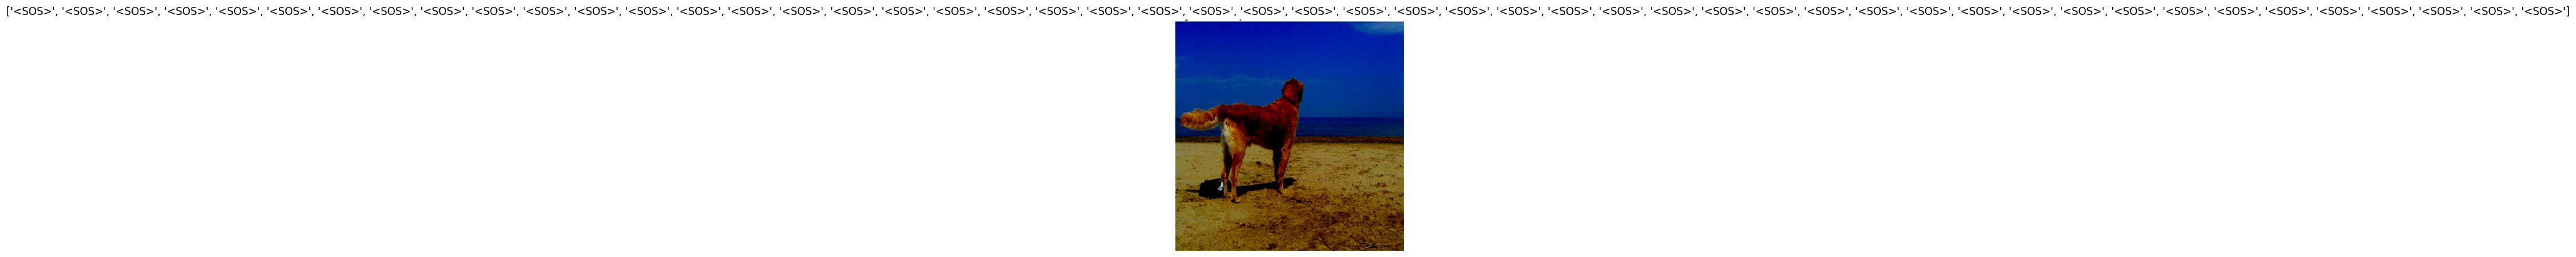

In [ ]:
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load trained model
#test_model = torch.load("./models/Train:100|Layers:2:40").to(device)

# Test image transforms
transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
# Get test image and transform to put through tensor
test_image1 = transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(0)
model.eval()
# Predictions
caption = model.caption_image(test_image1.to(device), dataset.vocab)

displayImage(test_image1.squeeze(0), caption)

Display Images

In [ ]:
# Test to see if works
a, b = train_dataset.__getitem__(7)
c, d = train_dataset.__getitem__(50)
displayImage(a,b)
displayImage(c,d)


TypeError: 'dict' object is not callable

: 